# DATASET WITH 'covid_year_timeline' and data only include >= 2017

Import Libraries

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer

import plotly.io as pio
pio.renderers
pio.renderers.default = "browser"

import Preprocess as pp
import Viz as viz

np.set_printoptions(precision = 3)

Set defaults

In [3]:
RANDOM_STATE = 42

df, column_trans, idx, df_orig = pp.preprocessData(data_from = 2017)


Split the dataset in X and y.

In [43]:
X = df.drop(columns=['log_scaled__total_sale_price', 'std_scale__year'])
y = df['log_scaled__total_sale_price']

Showing how the original dataset is preprocessed and transformed.

In [44]:
column_trans

ColumnTransformer(transformers=[('onehot', OneHotEncoder(),
                                 ['physical_zip_code', 'physical_city']),
                                ('log_scaled',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log1p'>)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['total_sale_price', 'assessed_building_value',
                                  'heated_area', 'unemploy_rate',
                                  'pop_growth_r...
                                  'crime', 'assessed_value_per_heated_area']),
                                ('mm_scaled', MinMaxScaler(),
                                 ['bath_fixtures', 'bath']),
                                ('std_scale', StandardScaler(),
                                 ['story_height', 'mort_rate', 'lumber_price',
                                  'metals_price', 'build_price', 'int_rate',
                                  'demand', 'wake_supply_index',
                                  'wake_demand_index', 'year']),
                                ('passthru', 'passthrough',
                                 ['electric', 'gas', 'water', 'sewer', 'all',
                                  'is_covid', 'covid_year_timeline'])])

Showing the index of the columns in the dataframe based on preprocess methods.

In [45]:
idx

{'onehot': slice(0, 43, None),
 'log_scaled': slice(43, 52, None),
 'mm_scaled': slice(52, 54, None),
 'std_scale': slice(54, 64, None),
 'passthru': slice(64, 71, None),
 'remainder': slice(0, 0, None)}

# K-Means Clustering

We perform a Kmeans Clustering with the transformed dataset.

### Elbow Method

The k-means algorithm tries to minimize distortion, which is defined as the sum of the squared distances between each observation vector and its dominating centroid. Each step of the k-means algorithm refines the choices of centroids to reduce distortion.

The below we see the elbow point as # of clusters reference. We have to be careful using this because it is less releveant when the elbow point is not obvious.
As seen below, the elbow point is not very obvious. So we move to check with Silhouette Score.

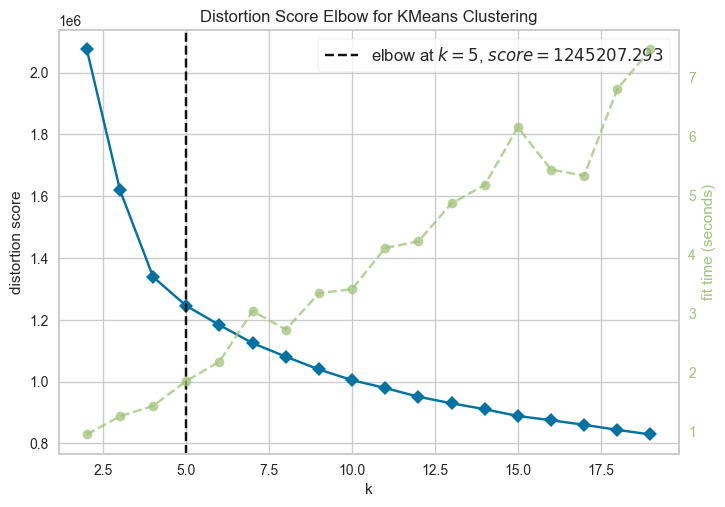

In [46]:
# initiate kmeans instance
kmeans = KMeans(init='k-means++', random_state=RANDOM_STATE)
k_start = 2
k_end = 20

# show results for full dataset
elb_visualizer = KElbowVisualizer(kmeans, k=(k_start, k_end)).fit(X).show()  

### Silhouette Score & Inertia, Davies-Bouldin Index and Calinski-Harabasz Index

This score shows the goodness of the clusters. The value of the silhouette coefﬁcient is between [-1, 1]. A score of 1 denotes the best meaning that the data point i is very compact within the cluster to which it belongs and far away from the other clusters. The worst value is -1. Values near 0 denote overlapping clusters.

Inertia measures how well a dataset was clustered by K-Means. It is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster. A good model is one with low inertia AND a low number of clusters ( K ).

c:\Users\choit\OneDrive\Coursera\SIADS696\Project2\SIADS-696-Milestone-II\Viz.py:263: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



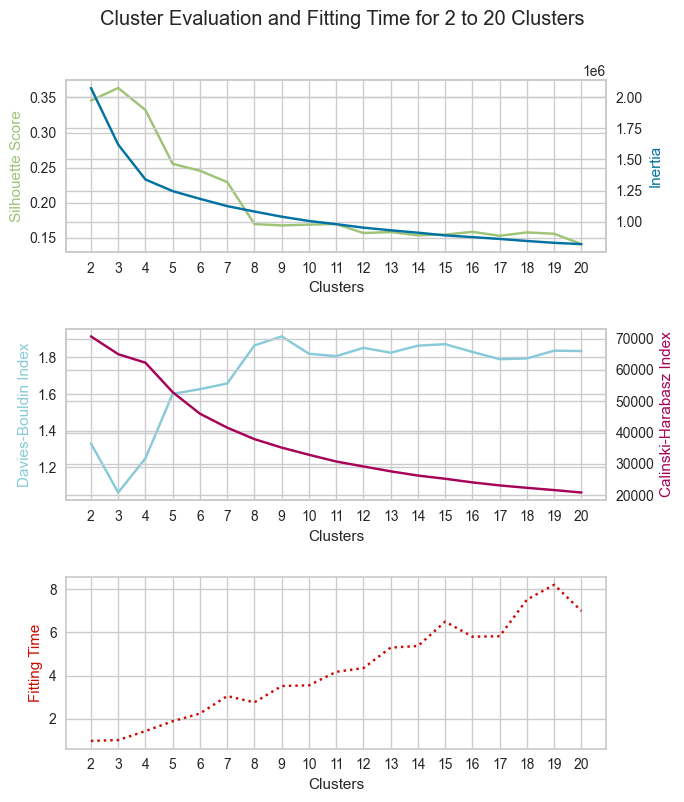

In [47]:
viz.plot_silhouette(X, kmeans=KMeans(init="k-means++", random_state=RANDOM_STATE))

Visualize Silhoutte Score and Scatter plot for 4, 5, 6 clusters because they have the high silhouette and low inertia.

We can see that they are not clustering well since some of the data point has negative silhouette scores. Further, the cluster centers all cluttered together and we don't see any nice clusters forming.

For n_clusters = 4 The average silhouette_score is : 0.33193944383450796
For n_clusters = 5 The average silhouette_score is : 0.25565115093303176
For n_clusters = 6 The average silhouette_score is : 0.24616004085711862


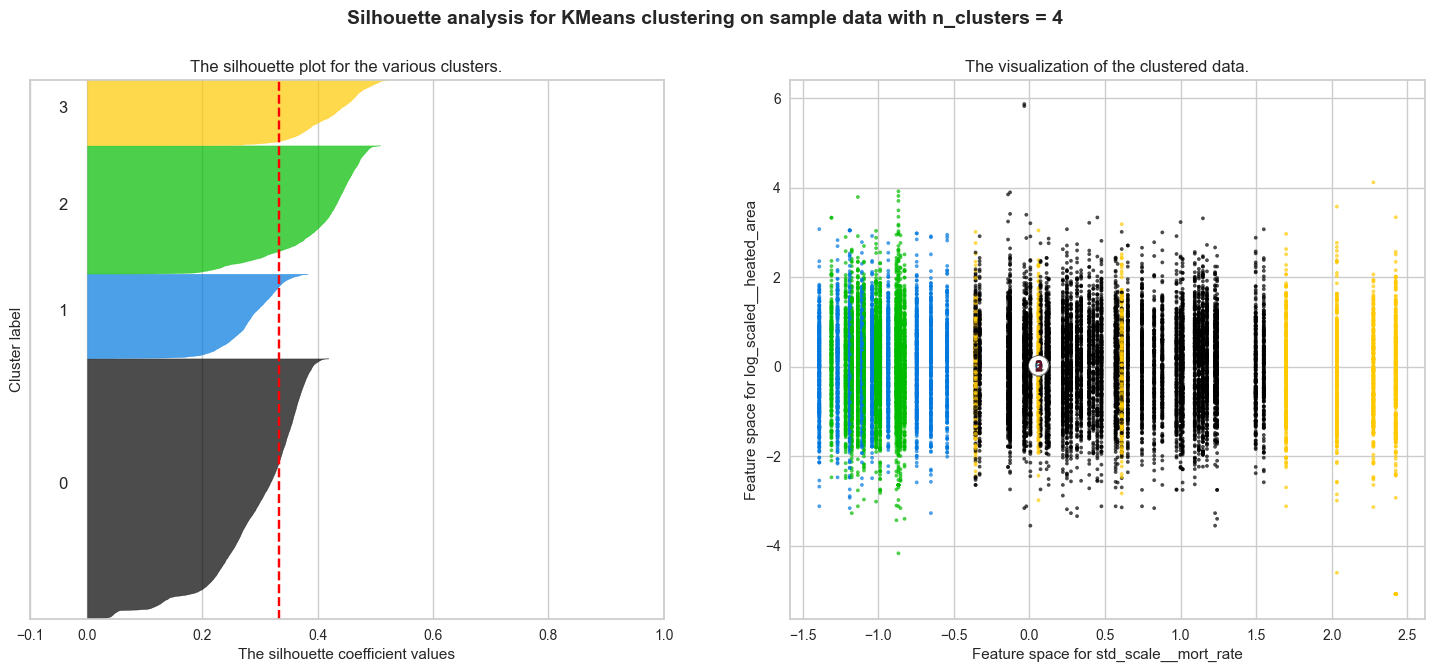

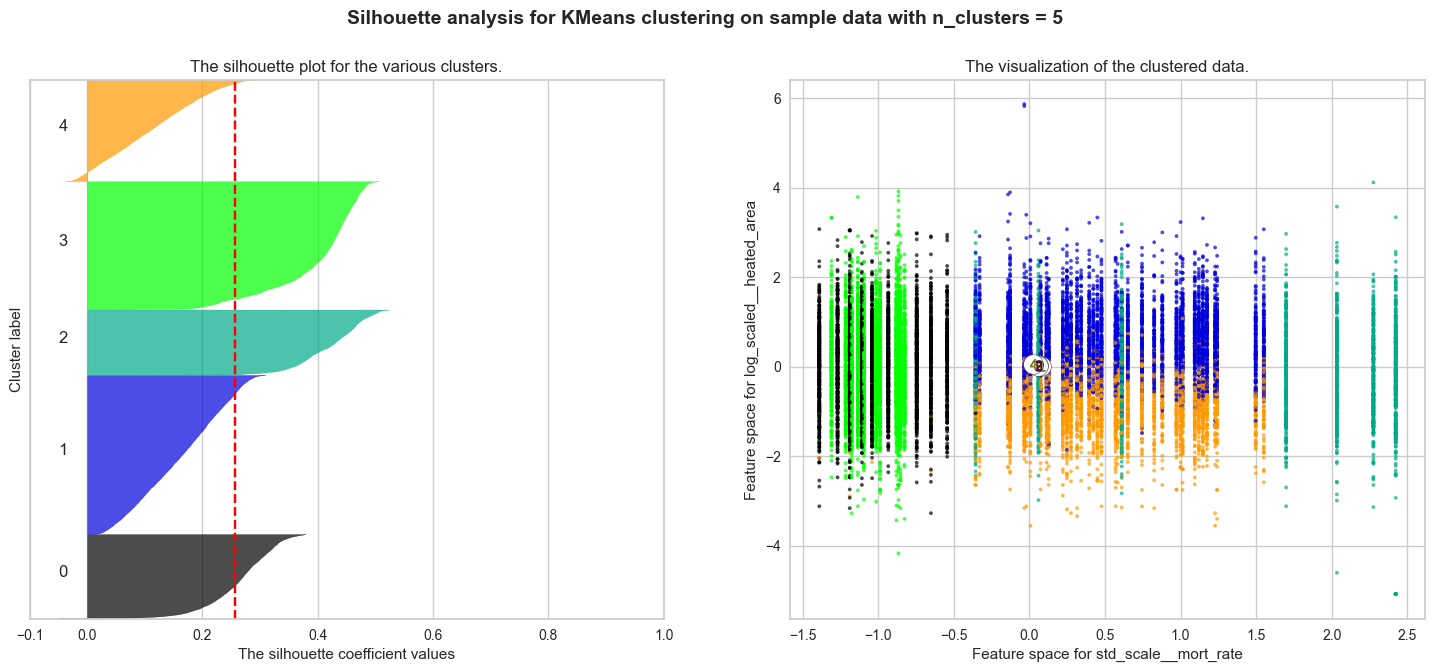

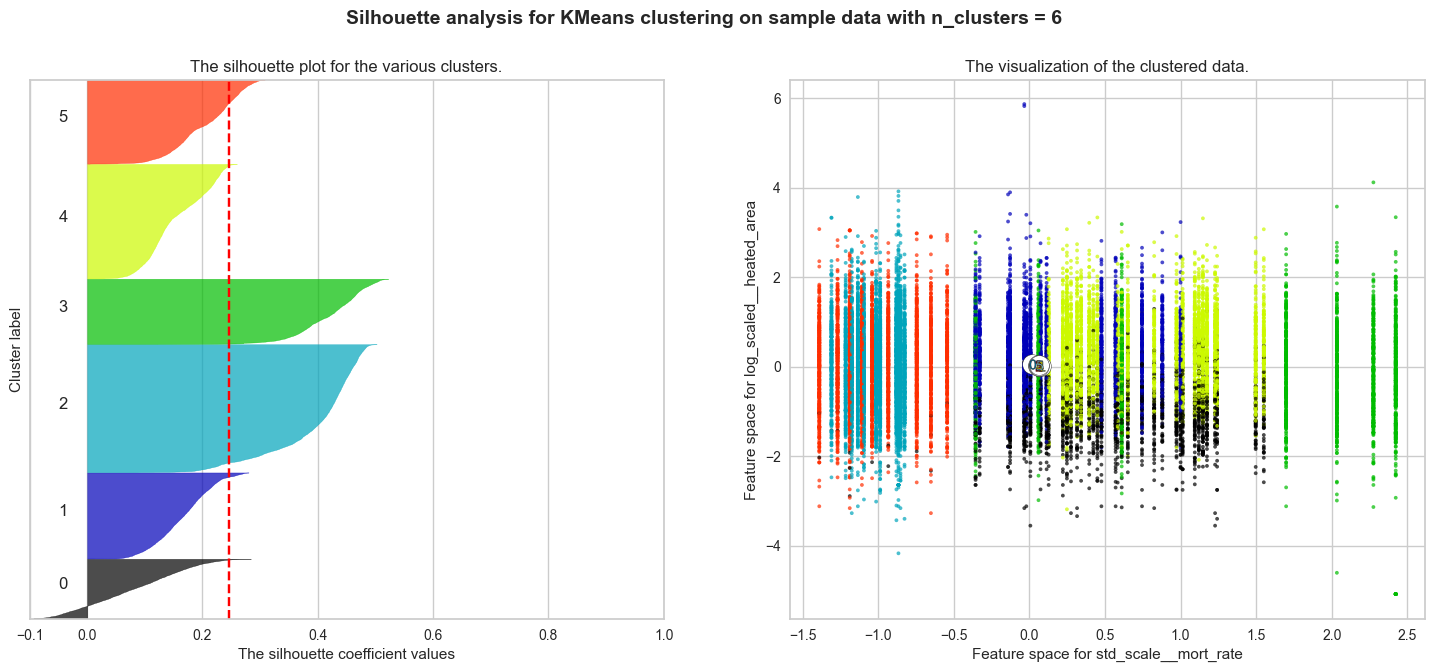

In [48]:
range_n_clusters = [4, 5, 6]
ax = 'std_scale__mort_rate'
ay = 'log_scaled__heated_area'

viz.draw_silhouette(X, k=range_n_clusters, ax=ax, ay=ay, random_state=RANDOM_STATE, sample=20000)

# Kmeans with PCA

### PCA


PCA allows to project the data from the original 70-dimensional space into a lower dimensional space. Subsequently, we can use PCA to project into a 2-dimensional space and plot the data and the clusters in this new space. - sklearn

In [49]:
pca = PCA(n_components=None, random_state=RANDOM_STATE)
pca.fit(X)

PCA(random_state=42)

Scree Plot helps us to visually decide how many PC to use. In practice, we take PCs with cumulative explained variance between 70% to 90%

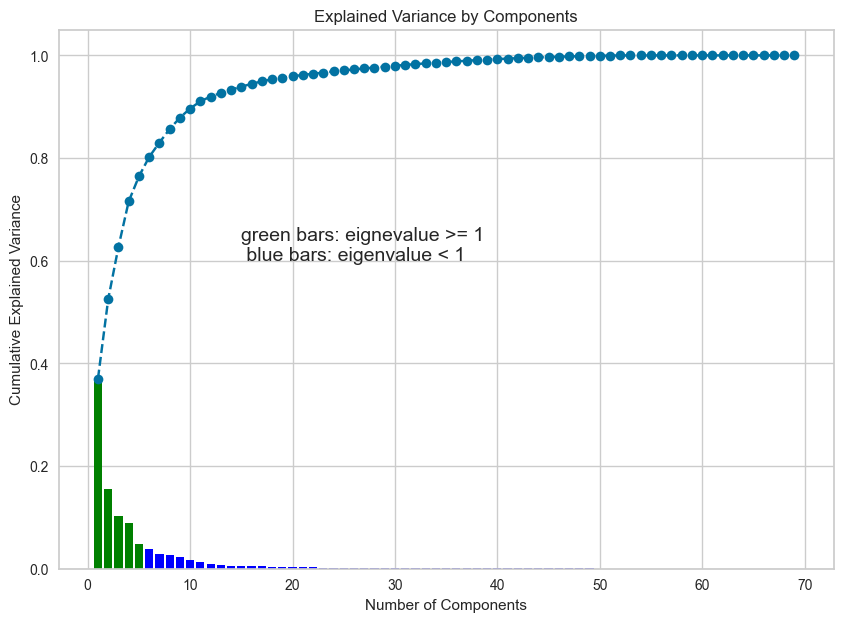

In [50]:
viz.make_PCA_screeplot(pca)

In [51]:
cum_explained = 0
pc_ct = 0

for i, val in enumerate(pca.explained_variance_):
    if val >= 1:
        cum_explained = cum_explained + pca.explained_variance_ratio_[i]
        pc_ct += 1 
        print('PC'+str(i+1)+' explained variance ratio is '+str(pca.explained_variance_ratio_[i]))

print('Cumulative explained variance ratio for the '+str(pc_ct)+' PCs with eigenvalues >= 1 is '+str(cum_explained))


PC1 explained variance ratio is 0.37039149513312886
PC2 explained variance ratio is 0.15475327113600437
PC3 explained variance ratio is 0.10184327281215305
PC4 explained variance ratio is 0.08854427945258875
PC5 explained variance ratio is 0.04878096929708255
Cumulative explained variance ratio for the 5 PCs with eigenvalues >= 1 is 0.7643132878309576


PCA with selected # of components

In [52]:
n = 5
pca_n = PCA(n_components=n, random_state=RANDOM_STATE)
pca_n_out_matrix = pca_n.fit_transform(X)

Top 10 features for each selected PC

In [53]:
viz.top_PC_loadings(pca_n, feature_names=X.columns.values, top_n=10)

,PC1 Top Feature,PC1 Loadings (ratio=0.37),PC2 Top Feature,PC2 Loadings (ratio=0.155),PC3 Top Feature,PC3 Loadings (ratio=0.102),PC4 Top Feature,PC4 Loadings (ratio=0.089),PC5 Top Feature,PC5 Loadings (ratio=0.049)
0,passthru__covid_year_timeline,0.5023,std_scale__mort_rate,0.4896,onehot__physical_city_raleigh,0.0765,log_scaled__unemploy_rate,0.4113,std_scale__story_height,0.6159
1,std_scale__build_price,0.3345,log_scaled__pop_growth_rate,0.4503,log_scaled__crime,0.0754,passthru__covid_year_timeline,0.3752,log_scaled__heated_area,0.3157
2,std_scale__metals_price,0.3157,std_scale__int_rate,0.3860,std_scale__demand,0.0489,std_scale__int_rate,0.2848,mm_scaled__bath,0.0405
3,log_scaled__covid_cases,0.3131,log_scaled__supply,0.3532,log_scaled__unemploy_rate,0.0466,log_scaled__pop_growth_rate,0.2293,log_scaled__unemploy_rate,0.0325
4,std_scale__lumber_price,0.3095,std_scale__metals_price,0.0418,onehot__physical_zip_code_27610,0.0312,log_scaled__crime,0.2020,onehot__physical_city_wake forest,0.0149
5,std_scale__wake_supply_index,0.3053,log_scaled__crime,0.0408,passthru__sewer,0.0224,log_scaled__covid_cases,0.1509,onehot__physical_zip_code_27587,0.0149
6,log_scaled__supply,0.2515,onehot__physical_city_raleigh,0.0120,passthru__covid_year_timeline,0.0224,std_scale__demand,0.1442,onehot__physical_zip_code_27616,0.0141
7,passthru__is_covid,0.1397,onehot__physical_zip_code_27610,0.0047,log_scaled__covid_cases,0.0215,passthru__is_covid,0.1213,onehot__physical_city_apex,0.0136
8,log_scaled__pop_growth_rate,0.1162,onehot__physical_zip_code_27529,0.0019,passthru__water,0.0214,log_scaled__supply,0.1199,std_scale__int_rate,0.0104
9,std_scale__wake_demand_index,0.0700,onehot__physical_city_garner,0.0019,onehot__physical_zip_code_27604,0.0191,log_scaled__assessed_value_per_heated_area,0.0420,log_scaled__pop_growth_rate,0.0098


Loadings heatmap image saved in folder
Shape before PCA:  (140588, 69)
Shape after PCA:  (140588, 5)


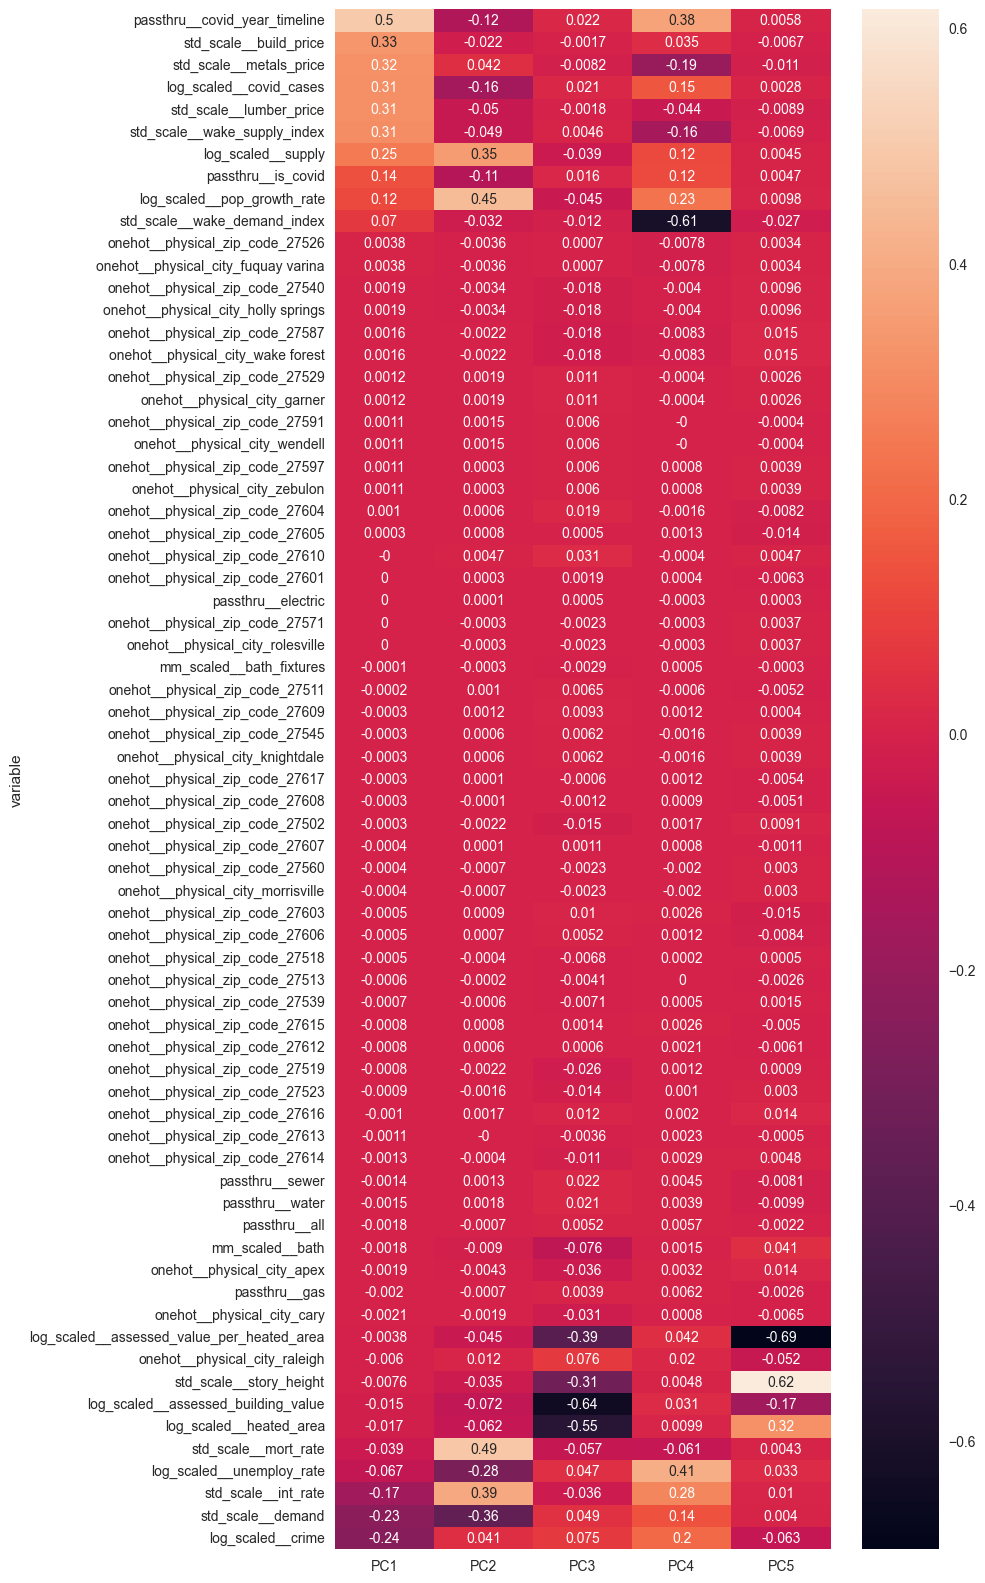

In [54]:
loadings_df = viz.make_loadings_df(pca_n, feature_names=X.columns.values)

plt.figure(figsize=(8,20))
sns.heatmap(loadings_df, annot=True, annot_kws={"size": 10})
plt.savefig('pca_n_component_loadings_heatmap_withTL.png')
print('Loadings heatmap image saved in folder')

print('Shape before PCA: ', X.shape)
print('Shape after PCA: ', pca_n_out_matrix.shape)


In [55]:
#top 10 features appears in both PC1 and PC2
pc1_top = loadings_df.sort_values('PC1', ascending=False).iloc[:,0].index[:10].to_list()
pc2_top = loadings_df.sort_values('PC2', ascending=False).iloc[:,1].index[:10].to_list()
unique = set(pc1_top+pc2_top)
print('There are '+str(len(unique))+' unique features in both PC1 and PC2 top 10 loaded features.')


There are 17 unique features in both PC1 and PC2 top 10 loaded features.


In [56]:
# change the pca-transformed matrix to df

pca_n_df = pd.DataFrame(pca_n_out_matrix, columns=['PC'+str(i) for i in range(1, pca_n.n_components_+1)])

# Kmeans with PCA Feature Space

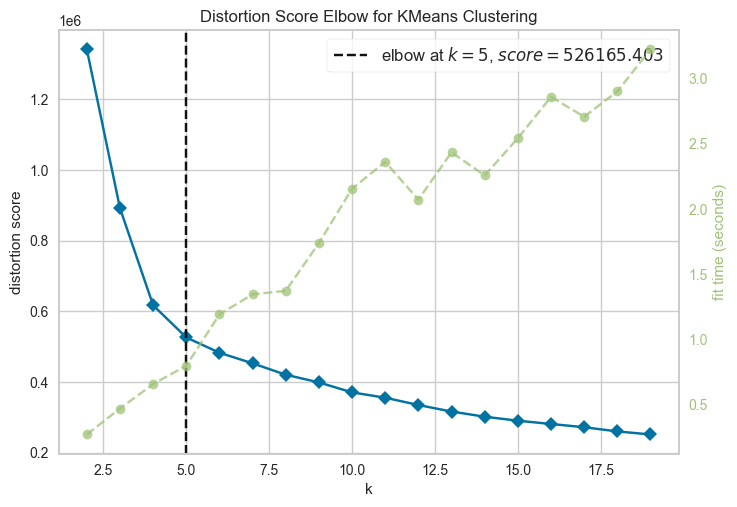

In [57]:
# initiate kmeans instance
kmeans = KMeans(init='k-means++', random_state=RANDOM_STATE)

# show results for full dataset
elb_visualizer = KElbowVisualizer(kmeans, k=(2,20)).fit(pca_n_out_matrix).show()  

c:\Users\choit\OneDrive\Coursera\SIADS696\Project2\SIADS-696-Milestone-II\Viz.py:263: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



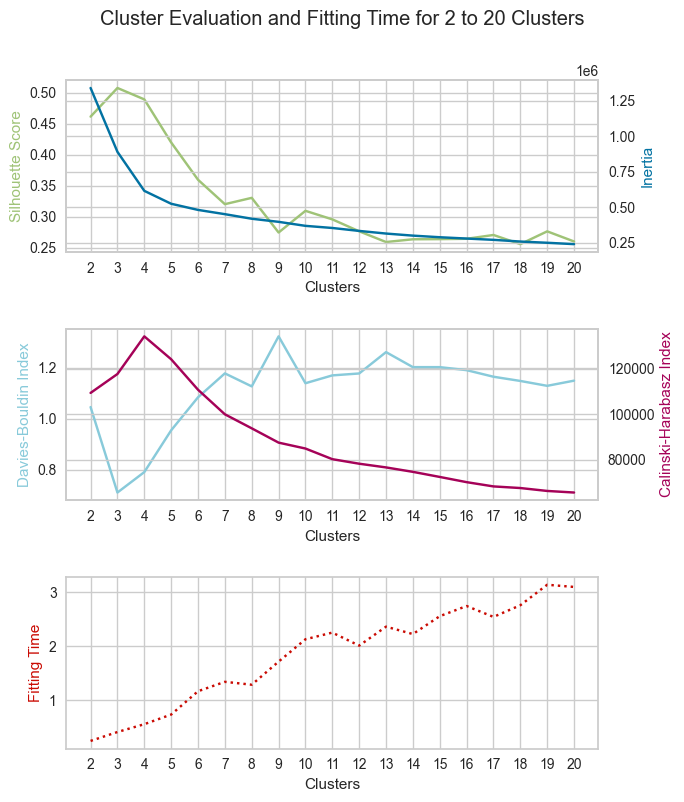

In [58]:
viz.plot_silhouette(pca_n_out_matrix, kmeans=KMeans(init="k-means++", random_state=RANDOM_STATE))

Based on the scores above, let's look at silhouette plots for 3, 4, and 5, 6 clusters.

For n_clusters = 3 The average silhouette_score is : 0.5079225985320922
For n_clusters = 4 The average silhouette_score is : 0.48951071744266544
For n_clusters = 5 The average silhouette_score is : 0.42072199056201787
For n_clusters = 6 The average silhouette_score is : 0.3608242890852024


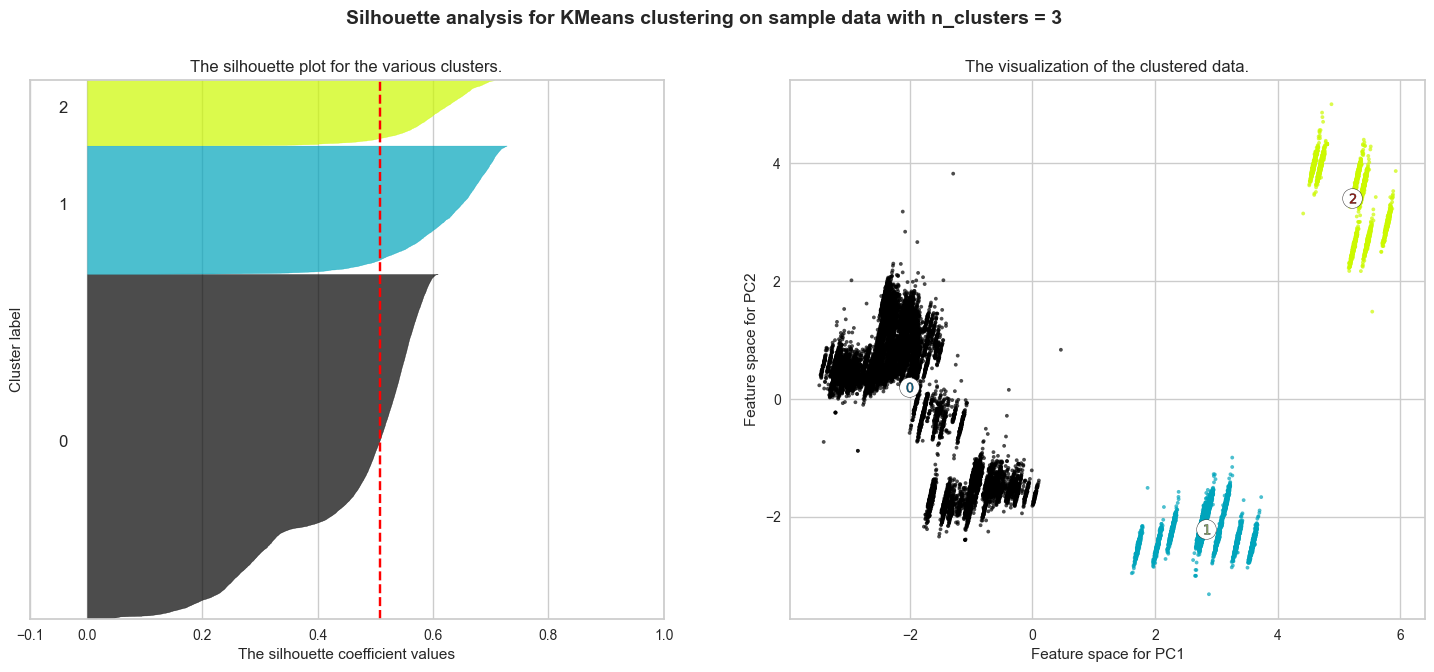

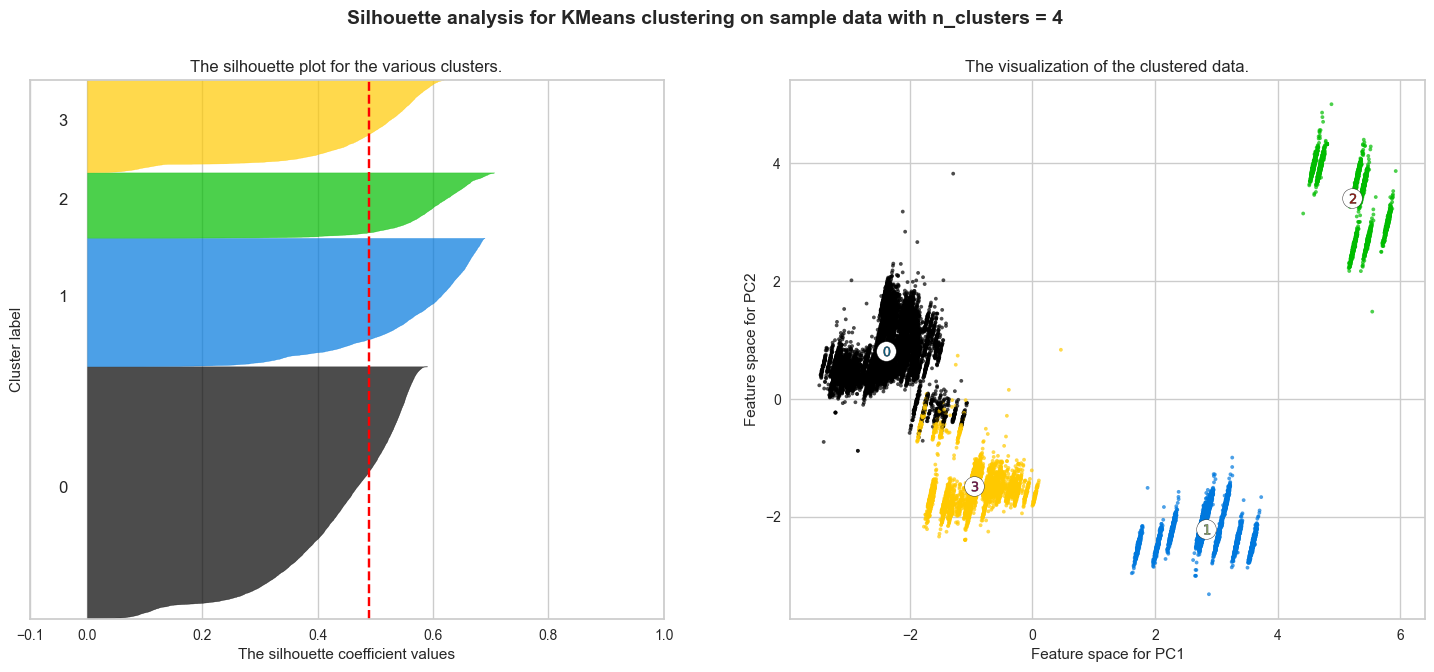

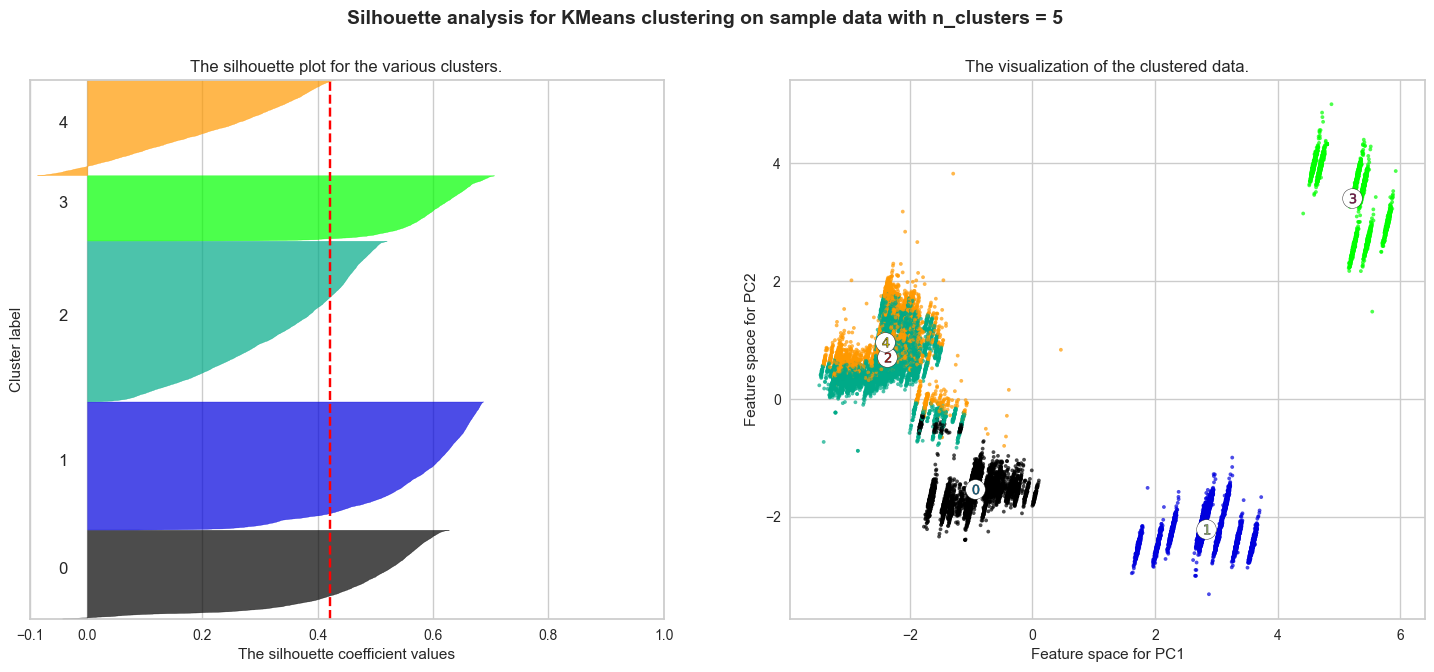

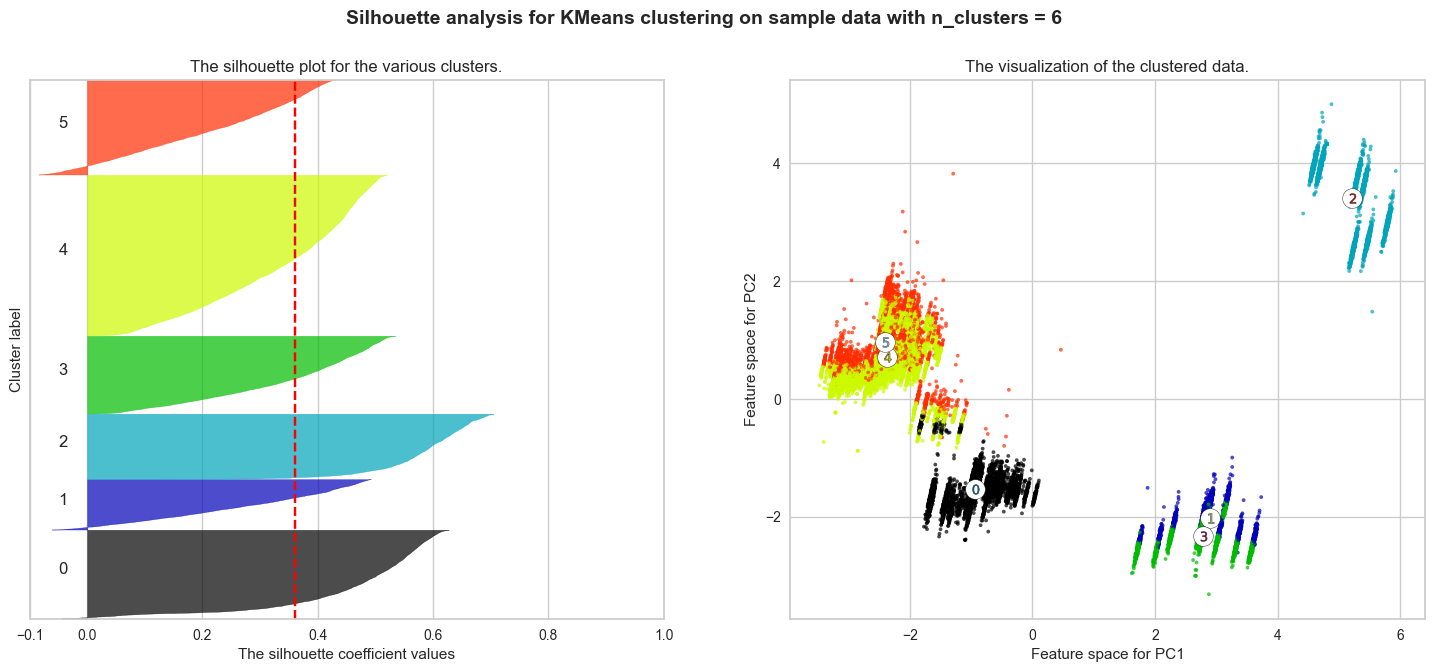

In [59]:
range_n_clusters = [3, 4, 5, 6]
ax = 'PC1'
ay = 'PC2'

viz.draw_silhouette(pca_n_df, k=range_n_clusters, ax=ax, ay=ay, random_state=RANDOM_STATE, sample=20000)

It looks like there are 5 clusters but the plot is best at 3 clusters, let's project the 3 clusters version in 3D scatter

We construct the full df for original preprocessing features, PC features, and cluster labels

In [60]:
#decided # of clusters
final_k = 3

#K-means clustering with PCA results
kmeans = KMeans(init='k-means++', n_clusters=final_k, random_state=RANDOM_STATE)
kmeans.fit_transform(X)

# create a new DF with original features and add PCA scores and assigned clusters
pca_kmeans_df = pd.concat([X.reset_index(drop=True), pd.DataFrame(pca_n_out_matrix)], axis =1)
pca_kmeans_df.columns.values[-n:] = ['PC'+str(i) for i in range(1, pca_n.n_components_+1)]

# add the last column with the clustering labels
pca_kmeans_df['ClusterLabels'] = kmeans.labels_

pca_kmeans_df.head()

,onehot__physical_zip_code_27502,onehot__physical_zip_code_27511,onehot__physical_zip_code_27513,onehot__physical_zip_code_27518,onehot__physical_zip_code_27519,onehot__physical_zip_code_27523,onehot__physical_zip_code_27526,onehot__physical_zip_code_27529,onehot__physical_zip_code_27539,onehot__physical_zip_code_27540,...,passthru__sewer,passthru__all,passthru__is_covid,passthru__covid_year_timeline,PC1,PC2,PC3,PC4,PC5,ClusterLabels
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,-3.0,-3.383357,0.697672,1.568069,-1.210314,-0.597655,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-3.0,-3.466860,0.302977,-1.961327,-1.122387,1.118346,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,-3.0,-3.366646,0.819802,2.617864,-1.287591,0.400864,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-3.0,-3.012759,0.680134,1.800678,-1.521242,-1.255632,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,-3.0,-3.380059,0.710882,1.665649,-1.215591,-0.032804,0


### K-means clustering with PCA results

In [61]:
# Biplot - same thing as above but now with PC and loadings
loadings = pca_n.components_.T * np.sqrt(pca_n.explained_variance_)
features = X.columns.to_list()
color = pca_kmeans_df['ClusterLabels'].astype(str)

fig = px.scatter(
    pca_n_out_matrix, x=0, y=1, color=color,
    color_discrete_sequence=px.colors.qualitative.Set2,
    #color_continuous_scale=px.colors.sequential.Purpor #px.colors.diverging.Sunset
)
fig.update_traces(marker_size = 2)

for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
        )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
        )

fig.write_html("pca_biplot_with_covid_timeline_withTL_2017.html")
#fig.show()

In [64]:
# Biplot - only for top features in PC1 and PC2
loadings = pca_n.components_.T * np.sqrt(pca_n.explained_variance_)
features = X.columns.to_list()

fig = px.scatter(
    pca_n_out_matrix, x=0, y=1, color=X.std_scale__build_price,
    labels = {
        '0' : "PC1 ("+str(round(pca.explained_variance_ratio_[0]*100,1))+'%'+' of Var)', 
        '1': "PC2 ("+str(round(pca.explained_variance_ratio_[1]*100,1))+'%'+' of Var)', 
        }
)
fig.update_traces(marker_size = 2)

for i, feature in enumerate(features):
    if feature in unique:
        fig.add_shape(
            type='line',
            x0=0, y0=0,
            x1=loadings[i, 0],
            y1=loadings[i, 1]
            )
        fig.add_annotation(
            x=loadings[i, 0],
            y=loadings[i, 1],
            ax=0, ay=0,
            xanchor="center",
            yanchor="bottom",
            text=feature,
            font=dict(
            size=9,
            ),
            )

fig.write_html("pca_biplot_with_covid_timeline_withTL_2017_PC1_PC2_builtprice.html")
#fig.show()

In [65]:
#Create 3D view of Kmeans on PC1, PC2, and PC3

fig3d = px.scatter_3d(
    pca_kmeans_df, 'PC1', 'PC2', 'PC3', 
    color= pca_kmeans_df['ClusterLabels'].astype(str),
    title='Kmeans Clustering Model - 3d Space for PC1, PC2 & PC3'
    )
fig3d.update_traces(marker_size = 2)
fig3d.update_layout(legend=({'itemsizing': 'constant'}))
fig3d.write_html('Kmeans_2017_cluster3d.html')